In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Changing directory to Session 14 project folder
% cd /content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/

/content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers


In [ ]:
# !pip install torch==1.8.0 torchvision==0.9.0 -qq
! pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.9 MB/s eta 0:10:19tcmalloc: large alloc 1147494400 bytes == 0x5611271f8000 @  0x7f78e486c615 0x5610ee0893bc 0x5610ee16a18a 0x5610ee08c1cd 0x5610ee17eb3d 0x5610ee100458 0x5610ee0fb02f 0x5610ee08daba 0x5610ee1002c0 0x5610ee0fb02f 0x5610ee08daba 0x5610ee0fccd4 0x5610ee17f986 0x5610ee0fc350 0x5610ee17f986 0x5610ee0fc350 0x5610ee17f986 0x5610ee0fc350 0x5610ee08df19 0x5610ee0d1a79 0x5610ee08cb32 0x5610ee1001dd 0x5610ee0fb02f 0x5610ee08daba 0x5610ee0fccd4 0x5610ee0fb02f 0x5610ee08daba 0x5610ee0fbeae 0x5610ee08d9da 0x5610ee0fc108 0x5610ee0fb02f
     |█████████████████               | 1055.7 MB 1.6 MB/s eta 0:09:27tcmalloc: large alloc 1434370048 bytes == 0x56116b84e000 @  0x7f78e486c615 0x5610ee0893bc 0x5610ee16a18a 0x5610ee08c1cd 0x5610ee17eb3d 0x5610ee100458 0x5610ee0fb02f 0x5610ee08daba 0x5610ee1002c0 0x5610ee0fb02f 0x5610ee08daba 0x5610ee0fccd4 0x5610ee17f986 0x5610ee0fc3

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.8.0+cu111 True


In [ ]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load an image for a demo

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [ ]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

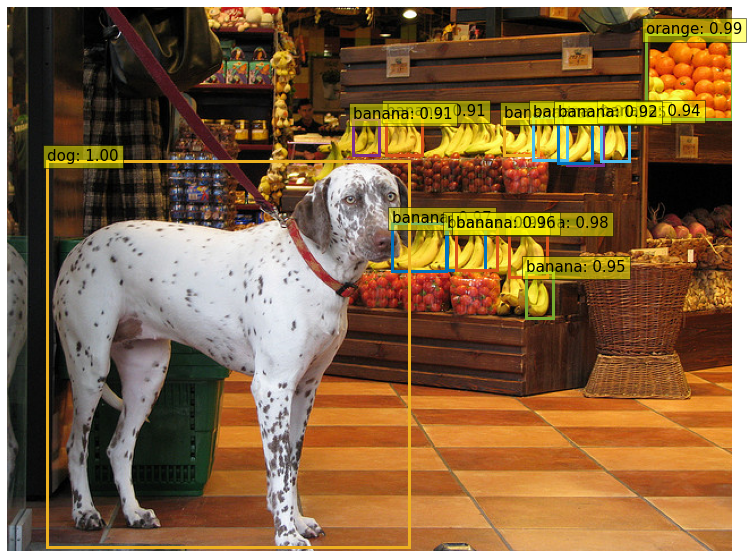

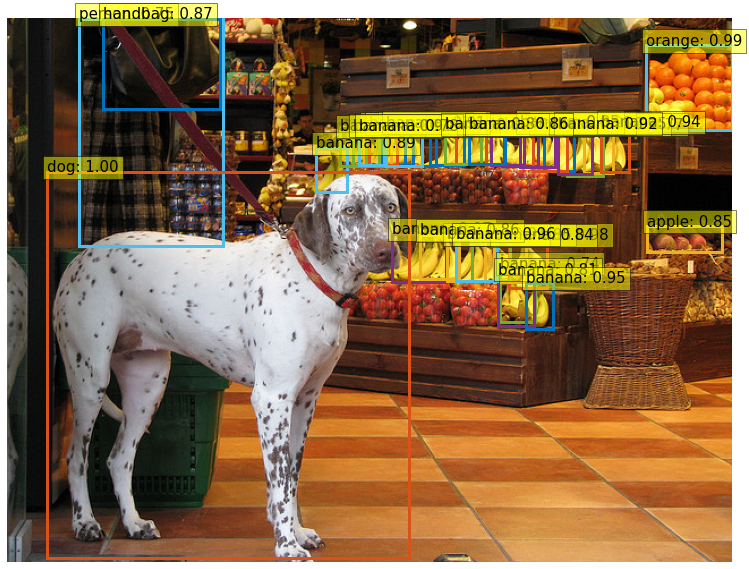

In [ ]:
for threshold in [0.9, 0.7]:
  
  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

## Clone my custom code of DETR

Clone [my fork](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`. My fork can do that.


In [ ]:
! ls 

d2			    engine.py	models	     requirements.txt	   util
datasets		    hubconf.py	outputs      run_with_submitit.py
detr-r50_no-class-head.pth  LICENSE	__pycache__  test_all.py
Dockerfile		    main.py	README.md    tox.ini


In [ ]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 284.62 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (131/131), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

In [ ]:
first_class_index = 1

We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [ ]:
!mkdir -p /content/data/custom/annotations/

!cp /content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/mask/annotations/train_mask.json /content/data/custom/annotations/custom_train.json
!cp /content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/mask/annotations/val_mask.json /content/data/custom/annotations/custom_val.json

!mkdir -p /content/data/custom/train2017/

!cp /content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/mask/train/*.jpg /content/data/custom/train2017/

!mkdir -p /content/data/custom/val2017/

!cp /content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/mask/val/*.jpg /content/data/custom/val2017/

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
dataDir='/content/data/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
cats

[{'id': 1, 'name': 'mask', 'supercategory': 'Defect'}]

In [ ]:
nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

Categories: ['mask']


In [ ]:
nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Super-categories: {'Defect'}


In [ ]:
# load and display image
catIds = coco.getCatIds(catNms=['mask']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°54
Image name: /content/data/custom//train2017/m6.jpg


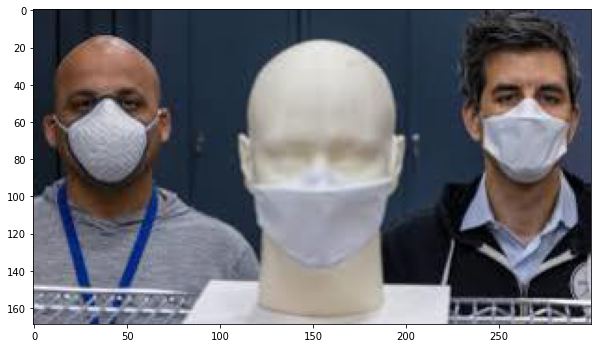

In [ ]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

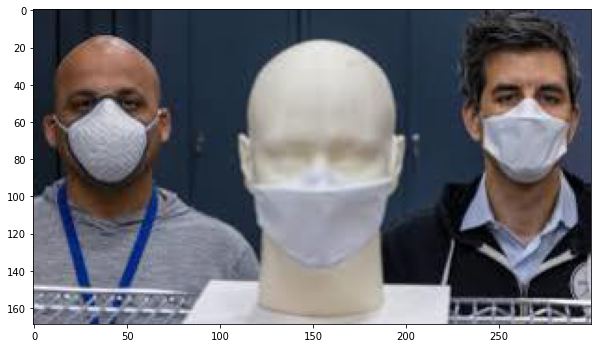

In [ ]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

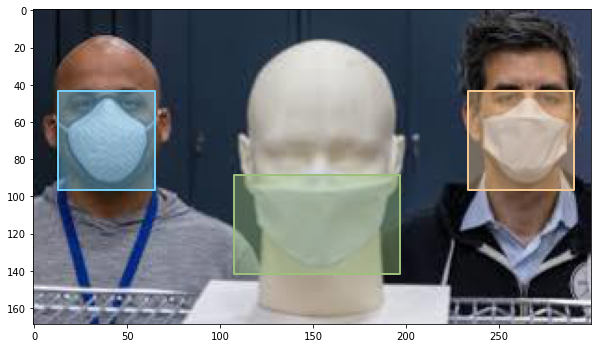

In [ ]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [ ]:
assert(first_class_index in [0, 1])

if first_class_index == 0:

  # There is one class, balloon, with ID n°0.

  num_classes = 1

  finetuned_classes = [
      'mask',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°1 here.  

else:

  # There is one class, balloon, with ID n°1.
  #
  # However, DETR assumes that indexing starts with 0, as in computer science,
  # so there is a dummy class with ID n°0.
  # Caveat: this dummy class is not the `no_object` class reserved by DETR.

  num_classes = 2

  finetuned_classes = [
      'N/A', 'mask',
  ]

  # The `no_object` class will be automatically reserved by DETR with ID equal
  # to `num_classes`, so ID n°2 here.

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 1
Parameter num_classes: 2
Fine-tuned classes: ['N/A', 'mask']


In [ ]:
%cd /content/detr/

/content/detr


**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

In [ ]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/data/custom/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 20

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/data/custom/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=20, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279495
loading annotations into memory...
Done (t=0.00s)
creating index...
i

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [ ]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [Path('outputs/')]

As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

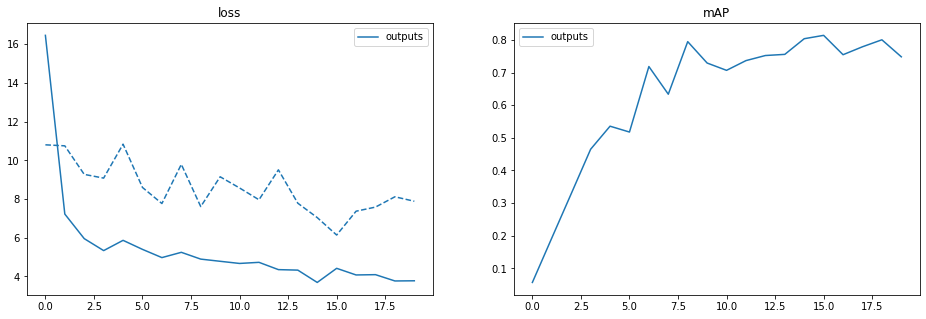

In [ ]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

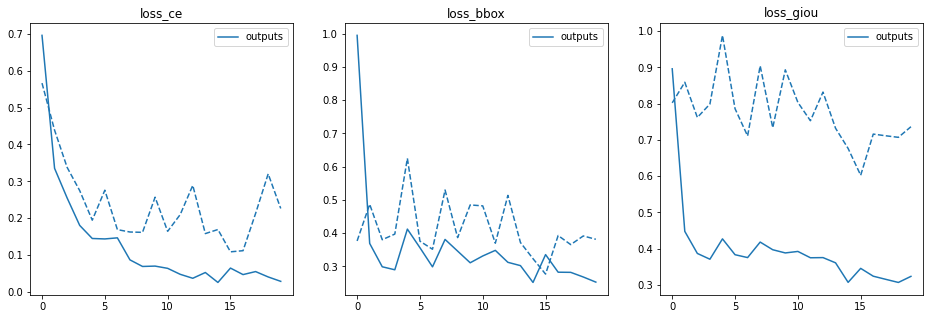

In [ ]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

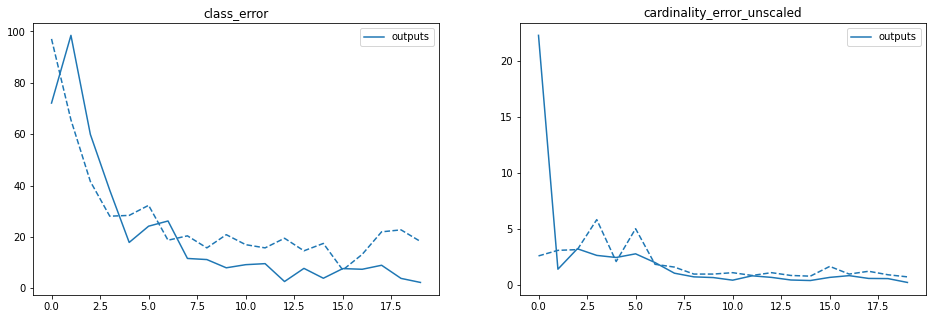

In [ ]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [ ]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


### Boilerplate functions to display fine-tuned results

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None, img_name_save=''):
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig(img_name_save, bbox_inches='tight')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model, img_name, dataset='train'):

  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)
    if dataset == 'val':
      f = '/content/gdrive/MyDrive/TSAI-EVA-7.0/14_DETR_End_to_end_Object_Detection_with_transformers/mask/results/'+img_name+'_t_'+str(threshold)+'.jpg'
      plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled, f)
    else:
      plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled, '')

### With a training image

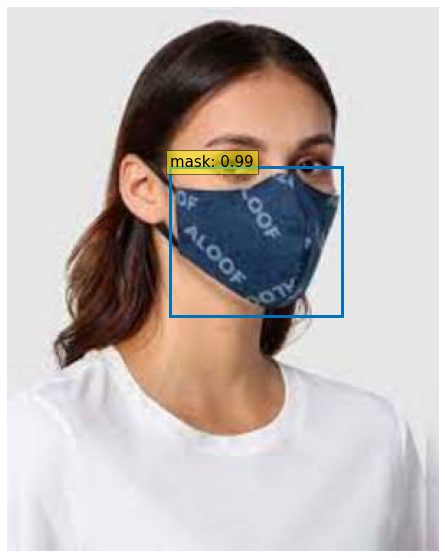

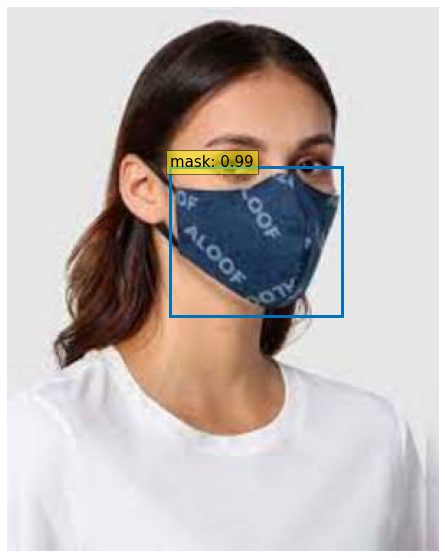

In [ ]:
from PIL import Image

dir = '/content/data/custom/train2017/'
img_name = 'm1'
im = Image.open(dir+img_name+'.jpg')

run_worflow(im,
            model, img_name, 'train')

### With a validation image

In [144]:
from PIL import Image

In [145]:
for i in range(66, 81):

  dir = '/content/data/custom/val2017/'
  img_name = 'm'+str(i)
  im = Image.open(dir+img_name+'.jpg')

  run_worflow(im,
              model, img_name, 'val')

Output hidden; open in https://colab.research.google.com to view.